In [284]:
import requests
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [285]:
data = pd.read_csv('accidents.csv', header = None)

In [286]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,79,80,81,82,83,84,85,86,87,88
0,56a72710-563d-410e-a744-468d2421092e,"Forecaster, CAIC",2/20/2018 7:00,Known,Estimated,38.008880,-107.873070,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{""Convex Slope""}"
1,6e872258-f60c-47bb-b6eb-484cc0fe3e89,"Forecaster, CAIC",12/19/2024 19:00,Estimated,Unknown,39.682316,-105.930845,f,f,t,...,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{}
2,22315e1b-b4cf-4de4-9c1b-9a3d124db2d4,"Forecaster, CAIC",1/22/2012 19:00,Known,Unknown,40.506490,-105.886230,f,f,t,...,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{}
3,4cc8fd48-c67f-40c3-963f-1c3bbed8676b,"Forecaster, CAIC",1/22/2012 7:00,Known,Unknown,39.886920,-105.760660,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50f496f8-21d1-4a6f-a250-8b7c821810c1,"Forecaster, CAIC",1/14/2018 19:00,Known,Unknown,38.689060,-106.355380,f,f,t,...,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{}


In [287]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308 entries, 0 to 307
Data columns (total 89 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       308 non-null    object 
 1   1       296 non-null    object 
 2   2       308 non-null    object 
 3   3       308 non-null    object 
 4   4       294 non-null    object 
 5   5       308 non-null    float64
 6   6       308 non-null    float64
 7   7       42 non-null     object 
 8   8       42 non-null     object 
 9   9       42 non-null     object 
 10  10      308 non-null    object 
 11  11      200 non-null    object 
 12  12      109 non-null    object 
 13  13      308 non-null    object 
 14  14      308 non-null    int64  
 15  15      199 non-null    object 
 16  16      213 non-null    object 
 17  17      308 non-null    object 
 18  18      20 non-null     float64
 19  19      256 non-null    object 
 20  20      285 non-null    object 
 21  21      12 non-null     object 
 22  22

In [288]:
#I used excel to identify the columns worth keeping, then converted their column letters into array positions
#I will keep these columns
cols_to_keep = [2, 5, 6, 19, 20, 30, 46]

avalanche_df = data[cols_to_keep]

#Now we should have the unique accident ID, date, latitude, longitude, avalanche type, aspect, elevation, and slope degree
avalanche_df.head()

,2,5,6,19,20,30,46
0,2/20/2018 7:00,38.008880,-107.873070,HS,N,11400.0,NaN
1,12/19/2024 19:00,39.682316,-105.930845,NaN,W,11600.0,NaN
2,1/22/2012 19:00,40.506490,-105.886230,NaN,NaN,NaN,NaN
3,1/22/2012 7:00,39.886920,-105.760660,NaN,N,10400.0,NaN
4,1/14/2018 19:00,38.689060,-106.355380,SS,NE,11200.0,35.0


In [289]:
#Now I'll name the columns that we want to keep
avalanche_df.columns = ['Date','Latitude','Longitude','Avalanche Type','Aspect','Elevation','Slope Degree']

In [290]:
#Lets check and see how it looks with the column names
avalanche_df.head()

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree
0,2/20/2018 7:00,38.008880,-107.873070,HS,N,11400.0,NaN
1,12/19/2024 19:00,39.682316,-105.930845,NaN,W,11600.0,NaN
2,1/22/2012 19:00,40.506490,-105.886230,NaN,NaN,NaN,NaN
3,1/22/2012 7:00,39.886920,-105.760660,NaN,N,10400.0,NaN
4,1/14/2018 19:00,38.689060,-106.355380,SS,NE,11200.0,35.0


In [291]:
#Lets see how many Avalanche Types (the Y of our model) we are missing
avalanche_df['Avalanche Type'].isna().sum()

52

In [292]:
#Lets compare that to how many non-nan values we have
avalanche_df['Avalanche Type'].count()

256

In [293]:
#And then the total length of the column
len(avalanche_df['Avalanche Type'])

308

In [294]:
#We cannot impute, guess, or leave missing values in the target values unfortunately. This would break the training process of the model. 
#For the sake of this project, I will need to drop the 50 missing rows.
avalanche_df = avalanche_df.dropna(subset = ['Avalanche Type'])


In [295]:
#Next, lets check for duplicate values, the CAIC warned there may be duplicate values reported for avalanche accidents.
#We will start by checking for total duplicate values in the list. Accidents with the same latitude, longitude, and time would be guaranteed duplicates
#So we will remove those. 
duplicates = avalanche_df[avalanche_df.duplicated(['Date','Latitude','Longitude'], keep = False)]
duplicates

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree
156,1/17/2019 7:00,38.808250,-106.413350,SS,E,12000.0,40.0
184,2/22/2025 19:00,39.800478,-105.772558,HS,NW,11470.0,NaN
198,1/17/2019 7:00,38.808250,-106.413350,SS,E,12000.0,40.0
219,2/22/2025 19:00,39.800478,-105.772558,HS,NW,NaN,NaN


In [296]:
#We have two duplicate avalanche accidents reported. Let's remove one.
avalanche_df = avalanche_df.drop_duplicates(['Date','Latitude','Longitude'],keep = False)

In [297]:
#And now I'll check again that it worked:
duplicates = avalanche_df[avalanche_df.duplicated(keep = False)]
duplicates

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree


<Axes: >

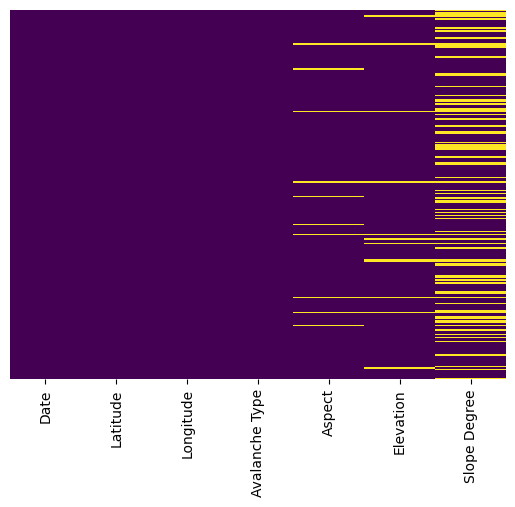

In [298]:
#I like to use this trick to visualize how much missing data we have. It looks like theres a lot of missing slope degree and some missing
#Data from other data types. Thankfully there are no missing dates, latitudes, or longitudes so I think we can feature engineer and fill these in
sns.heatmap(avalanche_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [299]:
#I'm going to focus on getting elevation sorted out first. Let me get familiar with elevation

<Axes: ylabel='Elevation'>

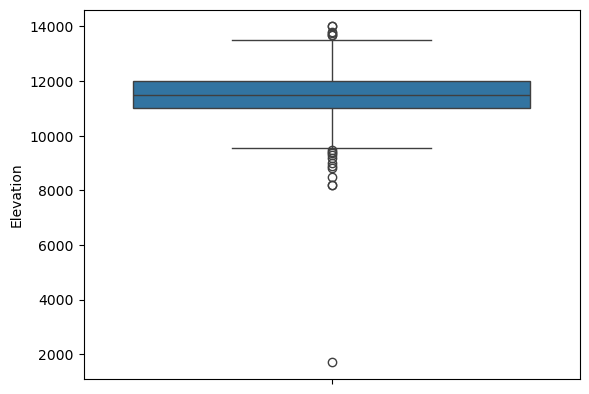

In [300]:
sns.boxplot(avalanche_df, y = 'Elevation')

In [301]:
#It appears the majority of avalanche accidents occur between 11,000 and 12,000 ft which makes sense, that is the majority of the peak elevations 
#within colorado.

In [302]:
#Let me find the < 2000ft outlier. Colorado is generally a minimum of 5280ft so 1700ft doesn't make sense.
avalanche_df['Elevation'].min()

1700.0

In [303]:
#Lets drop that row
avalanche_df = avalanche_df.drop(avalanche_df['Elevation'].idxmin())

In [304]:
#Now check our minimum
avalanche_df['Elevation'].min()

8200.0

In [305]:
#That seems more inline with avalanche elevations

In [306]:
#I found Elevation API that can extract Elevation from latitude and longitude. I'm going to try to use it:

def get_elevation(lat, lon):
    url = 'https://api.open-elevation.com/api/v1/lookup'
    params = {'locations': f'{lat},{lon}'}
    response = requests.get(url, params=params).json()
    elevation_meters = response['results'][0]['elevation']
    return elevation_meters * 3.28084

In [307]:
#Lets test it against an elevation we know. I will use row 1. 
get_elevation(39.682316, -105.930845)

11630.5778

In [308]:
#It gave us an elevation of 11,630 and our target elevation was 11,600!
#lets run it again on another test point to check it
get_elevation(38.008880, -107.873070)

11994.75104

In [309]:
#Not quite as accurate, it should have been 11,400ft. The free API may not have the highest resolution but it is relatively close
#and is also a free api. For the sake of this project is should work.

In [310]:
#Lets make a function to fill the 52 missing elevation values. I hope this works with their API
def fill_elevation(row):
    if np.isnan(row['Elevation']):
        return get_elevation(row['Latitude'], row['Longitude'])
    else:
        return row['Elevation']

avalanche_df['Elevation'] = avalanche_df.apply(fill_elevation, axis = 1)
        

In [311]:
#It looks like it worked, it filled in the missing values
avalanche_df.head()

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree
0,2/20/2018 7:00,38.00888,-107.87307,HS,N,11400.00000,NaN
4,1/14/2018 19:00,38.68906,-106.35538,SS,NE,11200.00000,35.0
6,3/12/2010 7:00,38.32872,-106.23696,SS,W,12000.00000,NaN
7,3/7/2019 7:00,39.49174,-106.11663,HS,W,11900.00000,NaN
8,11/24/2013 17:30,39.83408,-105.64865,SS,E,11194.22608,NaN


<Axes: >

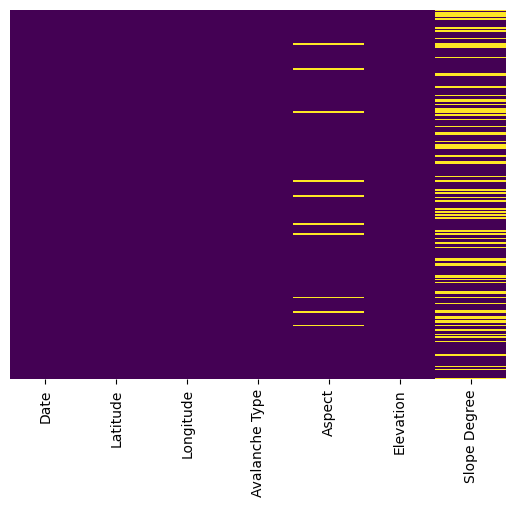

In [312]:
#Lets check
sns.heatmap(avalanche_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

<Axes: ylabel='Elevation'>

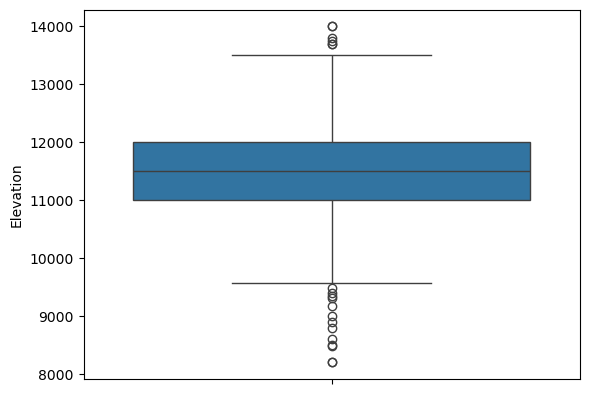

In [313]:
#And then lets check that it actually filled them in and kept our distribution
sns.boxplot(avalanche_df, y = 'Elevation')

In [314]:
#Great, now the last thing to do with the elevation column is set it's data type to integer
avalanche_df['Elevation'] = avalanche_df['Elevation'].astype(int)

In [315]:
#We have a lot of missing Slope Degree data. Slope degree is critical to the probability of an avalanche occurring and what type of avalanche
#may occur so we need to keep this row if we can. 
#I made detailed notes in my log about this, but most avalanches occur between 30 and 45 degrees according to online sources. Let's
#visualize the avalanche slope degrees and see where they are most commonly occuring in our data set.

#It looks like the maximum value of the column is an incorrectly entered slope degree. This was likely meant to be 35 degrees. I am
#going to set it to 35.
print(avalanche_df['Slope Degree'].dropna().max())

355.0


In [316]:
avalanche_df.loc[avalanche_df['Slope Degree'] == 355.0, 'Slope Degree'] = 35.0

In [317]:
print(avalanche_df['Slope Degree'].dropna().max())

50.0


In [318]:
#Great that is a much more reasonable maximum and lies within the range my research showed would be a reasonable max avalanche slope.

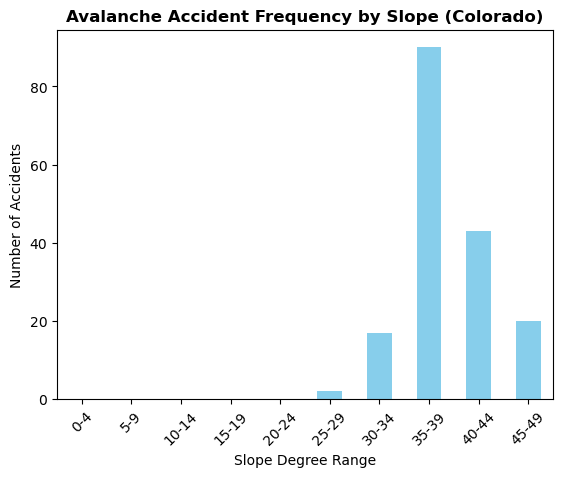

In [319]:
#Ok so now I'll make the bins to visualize where most common avalanches are occuring.

maximum_slope_degree = int(avalanche_df['Slope Degree'].dropna().max())

bins = range(0, maximum_slope_degree + 5, 5) #Create bins in groups of 5 degrees to see where the most avalanches occur.
labels = [f"{d}-{d+4}" for d in bins[:-1]] #Make labels for each of the bins giving a range of degrees in 5 degree increments
bin_df = pd.DataFrame() #I chose to make a separate data frame for this visualization
bin_df['Slope Bin'] = pd.cut(avalanche_df['Slope Degree'].dropna(), bins = bins, labels = labels, right = False) 

bin_counts = bin_df['Slope Bin'].value_counts().sort_index()
bin_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Slope Degree Range')
plt.ylabel('Number of Accidents')
plt.title('Avalanche Accident Frequency by Slope (Colorado)', fontweight = 'bold')
plt.xticks(rotation=45)
plt.show()

In [320]:
#Next let's look at what percent of the data each slope degree bin contributes to. I think this could be used
#To make a weighted distribution for filling in missing values
bin_percentages = (bin_counts / bin_counts.sum()) *100
bin_percentages.round(2)

Slope Bin
0-4       0.00
5-9       0.00
10-14     0.00
15-19     0.00
20-24     0.00
25-29     1.16
30-34     9.88
35-39    52.33
40-44    25.00
45-49    11.63
Name: count, dtype: float64

In [321]:
#So what I'll do is create weights from these numbers and also drop any that are 0
bin_weights = bin_percentages / 100
actual_bins = bin_weights[bin_weights > 0] 
actual_bins

Slope Bin
25-29    0.011628
30-34    0.098837
35-39    0.523256
40-44    0.250000
45-49    0.116279
Name: count, dtype: float64

In [322]:
#Alright! Looks like that should work.


#Map the bin labels to numeric range
bin_ranges = {
    '25-29' : (25,29),
    '30-34' : (30, 34),
    '35-39' : (35, 39),
    '40-44' : (40, 44),
    '45-49' : (45, 49)
}

def fill_slope_from_bins(n):
    
    #Make a list of bin labels
    bins = actual_bins.index.tolist() 

    #Get the probability associated with each bin
    degree_probs = actual_bins.values

    #Randomly select n bin labels given the probability of each bin
    selected_bins = np.random.choice(bins, size = n, p = degree_probs)

    #Then for each bin label, draw a random slope degree within that bins range 
    return [
        np.random.uniform(*bin_ranges[bin_label]) #Unpacks the bin range tuple and get a random slope degree within that bin range
        for bin_label in selected_bins
    ]

missing_index = avalanche_df['Slope Degree'].isnull()
avalanche_df.loc[missing_index, 'Slope Degree'] = fill_slope_from_bins(missing_index.sum())

In [323]:
#I'm going to check and see if we have any null values still.
avalanche_df[avalanche_df['Slope Degree'].isnull()]

,Date,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree


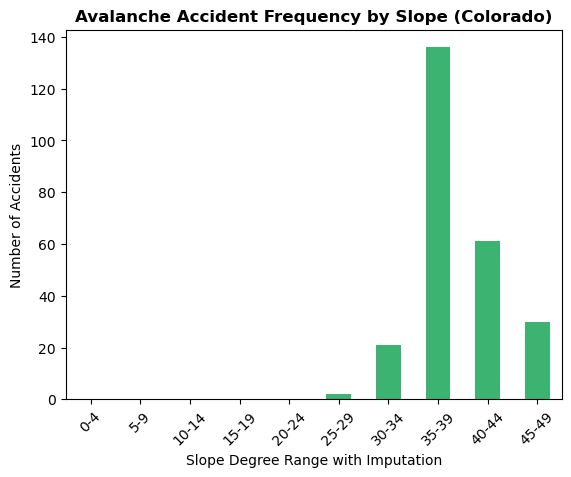

In [324]:
#So now we can look visualize the slope degree distirbution again with a bar plot and make sure we visually follow the 
#same distribution

maximum_slope_degree = int(avalanche_df['Slope Degree'].max())

bins = range(0, maximum_slope_degree + 5, 5)
labels = [f"{d}-{d+4}" for d in bins[:-1]]

bin_df_imputed = pd.DataFrame()
bin_df_imputed['Slope Bin'] = pd.cut(avalanche_df['Slope Degree'], bins = bins, labels = labels, right = False) 
bin_counts_imputed = bin_df_imputed['Slope Bin'].value_counts().sort_index()

bin_counts_imputed.plot(kind='bar', color='mediumseagreen')
plt.xlabel('Slope Degree Range with Imputation')
plt.ylabel('Number of Accidents')
plt.title('Avalanche Accident Frequency by Slope (Colorado)', fontweight = 'bold')
plt.xticks(rotation=45)
plt.show()

In [325]:
#It looks like we kept the overall shape but with much more data points and now we have no missing slope degree values

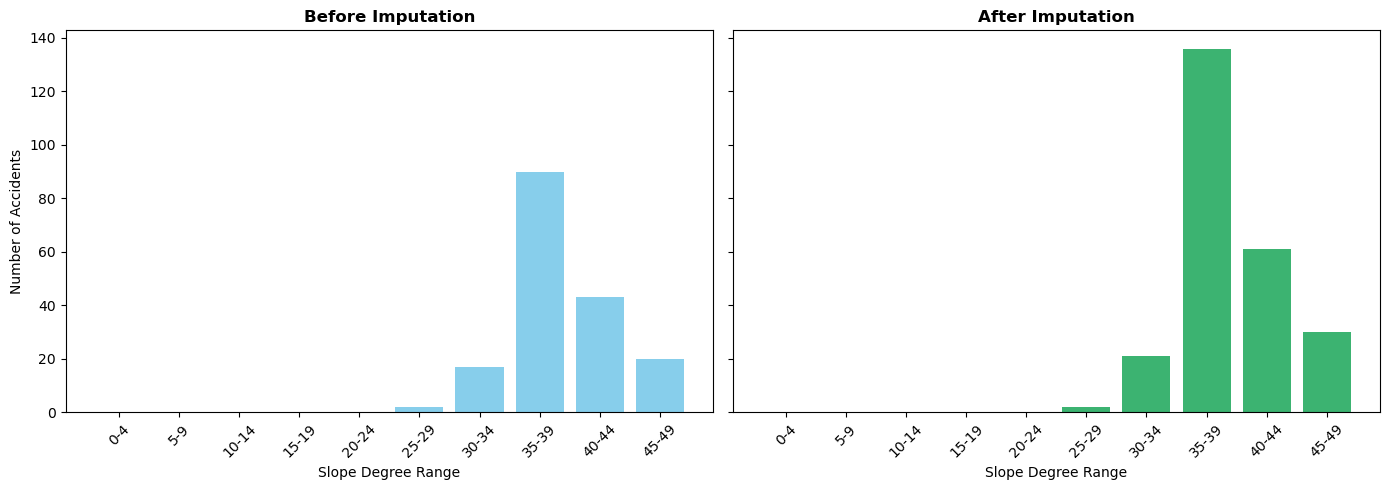

In [326]:
#Lets look at them side by side!
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

#Plot the before imputation
axes[0].bar(labels, bin_counts.values, color='skyblue')
axes[0].set_title('Before Imputation', fontweight='bold')
axes[0].set_xlabel('Slope Degree Range')
axes[0].set_ylabel('Number of Accidents')
axes[0].tick_params(axis='x', rotation=45)

#Plot the after imputation 
axes[1].bar(labels, bin_counts_imputed.values, color='mediumseagreen')
axes[1].set_title('After Imputation', fontweight='bold')
axes[1].set_xlabel('Slope Degree Range')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [327]:
#This is great, we've kept the same distribution of the data but increased our usable data significantly!

<Axes: >

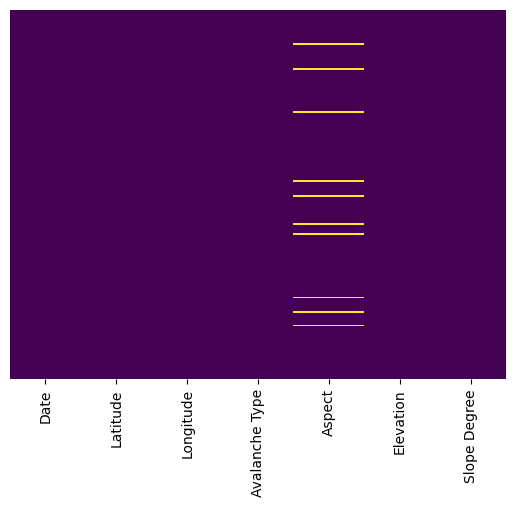

In [328]:
#Lets check where we're at on missing data
sns.heatmap(avalanche_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [329]:
#Lets see what percentage of the data each aspect accounts for:

aspect_count = avalanche_df['Aspect'].value_counts()
aspect_pcnt = aspect_count / aspect_count.sum()
aspect_pcnt

Aspect
NE    0.228216
E     0.186722
N     0.161826
NW    0.145228
SE    0.120332
W     0.074689
S     0.070539
SW    0.012448
Name: count, dtype: float64

In [330]:
aspects = aspect_pcnt.index.tolist()

#Get a list of the weights
aspect_probs = aspect_pcnt.values

#Find how many missing values we have - should be 10
number_missing = avalanche_df['Aspect'].isna().sum()

#Now randomly select the weighted aspect
aspects_imputed = np.random.choice(aspects, size = number_missing, p = aspect_probs)

#Now replace the missing indexes in the dataframe with the weightedimputed values
avalanche_df.loc[avalanche_df['Aspect'].isna(), 'Aspect'] = aspects_imputed

<Axes: >

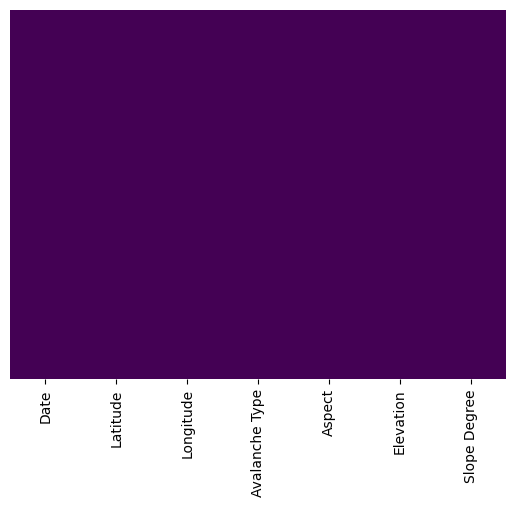

In [331]:
#Lets check now where we're at with missing data
sns.heatmap(avalanche_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

In [332]:
#Sweet! No missing data. Now I'll break date down into time of day and time of season

In [333]:
avalanche_df['Date'] = pd.to_datetime(avalanche_df['Date'])

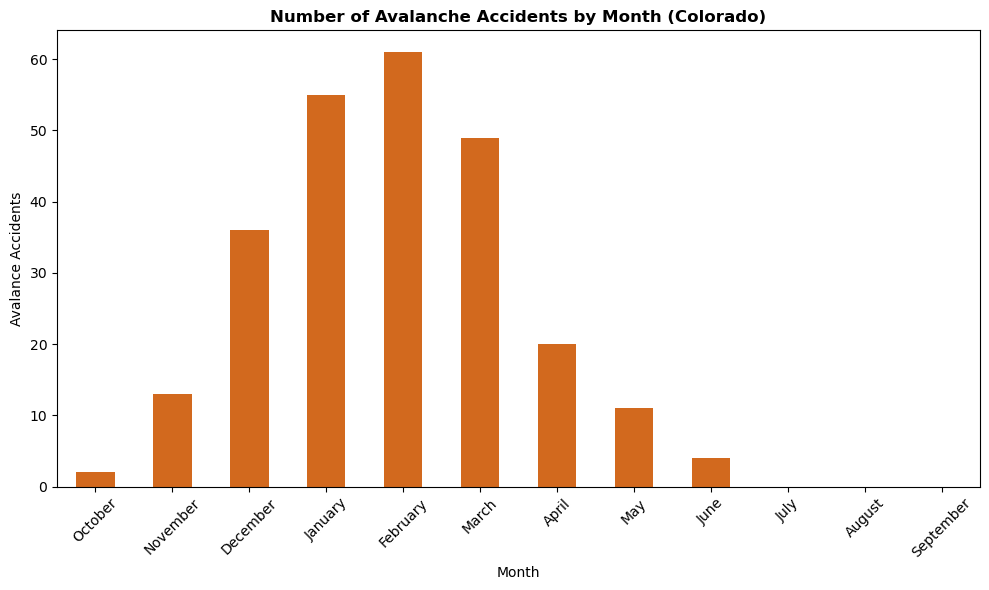

In [334]:
month_df = pd.DataFrame()
month_df['Month'] = avalanche_df['Date'].dt.month_name()

#Count avalanche accidents by month. I'm re-indexing in order from where we would consider the start of the season onwards.
monthly_counts = month_df['Month'].value_counts().reindex([
    'October', 'November', 'December', 'January', 'February', 'March',
    'April', 'May', 'June', 'July', 'August', 'September'
])

monthly_counts.plot(kind='bar', figsize=(10, 6), color='chocolate')
plt.xlabel('Month')
plt.ylabel('Avalance Accidents')
plt.title('Number of Avalanche Accidents by Month (Colorado)', fontweight='bold')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

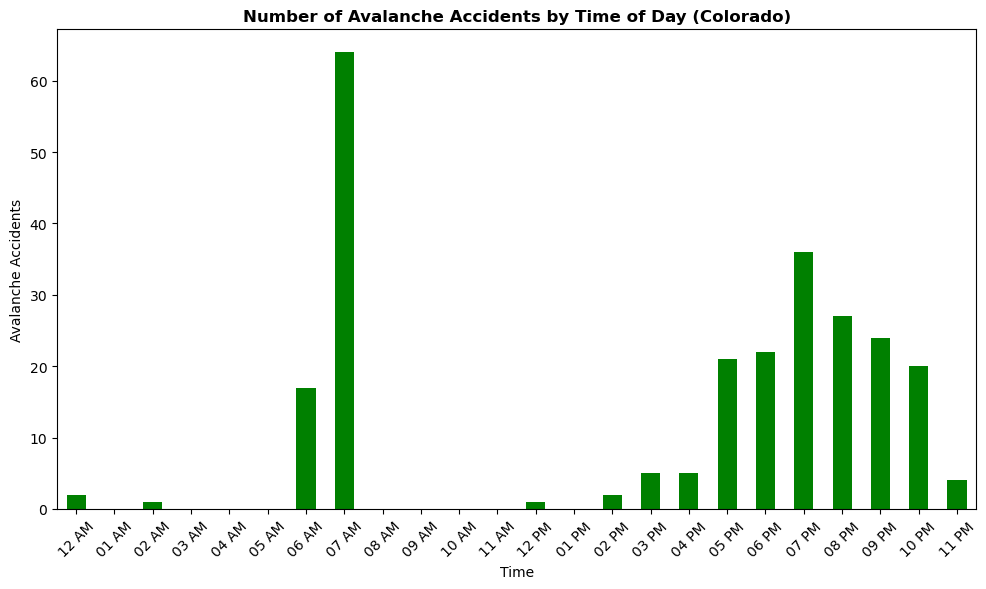

In [335]:
time_df = pd.DataFrame()
time_df['Hour'] = avalanche_df['Date'].dt.strftime('%I %p')

#Set the correct orders for the times (earliest to latest)
hour_order = pd.date_range("00:00", "23:00", freq="h").strftime('%I %p').unique()

#Count the number of accidents reported per hour and sort using the hour order
hour_counts = time_df['Hour'].value_counts().reindex(hour_order, fill_value=0)

#Plot the accidents by the hour from earliest to latest
hour_counts.plot(kind='bar', figsize=(10, 6), color='green')
plt.xlabel('Time')
plt.ylabel('Avalanche Accidents')
plt.title('Number of Avalanche Accidents by Time of Day (Colorado)', fontweight='bold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [336]:
#Interesting!! It looks like time won't be helpful. It's likeley that this is the time the avalanche was recorded, not the time 
#of the incident. The CAIC often reports avalanches on the same day of the event, so it makes sense the majority of avalanche
#accidents time stamps are in the evening. We won't use time as a feature like I originally thought we could.

In [337]:
#I'll write a function to categorize the month into season
def categorize_season(date):
    month = date.month
    if month in [11,12]: #November to December (Early Season)
        return "Early Season"
    elif month in [1,2]: #January to February (Mid Season)
        return "Mid Season"
    elif month in [3,4]: #March to April (Late Season)
        return "Late Season"
    else:
        return "Off Season"

avalanche_df['Season'] = avalanche_df['Date'].apply(categorize_season)

<Axes: xlabel='Season'>

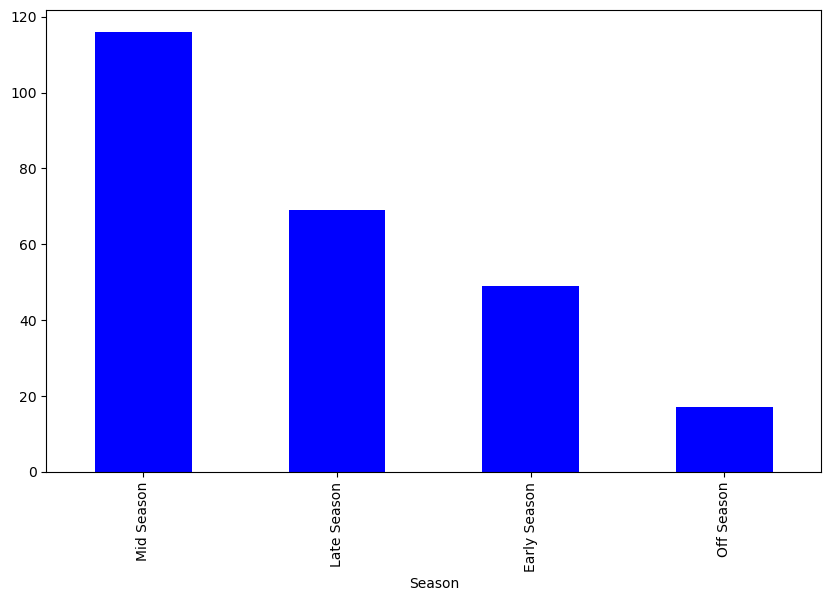

In [338]:
#We can create another visualization and see that the majority of avalanches occurred mid-season, with late season being more likely
#and early / off season being the least accidents. This is inline with my experience as a skier.
avalanche_df['Season'].value_counts().plot(kind='bar', figsize=(10, 6), color='blue')

In [339]:
#And move Season to be the first column. It just makes sense to me.
season_col = avalanche_df.pop('Season')  # Remove the column and save it
avalanche_df.insert(1, 'Season', season_col)  # Insert it at position 0 (first column)

In [340]:
print(avalanche_df.dtypes)

Date              datetime64[ns]
Season                    object
Latitude                 float64
Longitude                float64
Avalanche Type            object
Aspect                    object
Elevation                  int64
Slope Degree             float64
dtype: object


In [341]:
avalanche_df['Season'].unique()

array(['Mid Season', 'Late Season', 'Early Season', 'Off Season'],
      dtype=object)

In [342]:
avalanche_df['Avalanche Type'].unique()

array(['HS', 'SS', 'WL', 'WS', 'U', 'I', 'R', 'L', 'C'], dtype=object)

In [343]:
avalanche_df['Aspect'].unique()


array(['N', 'NE', 'W', 'E', 'NW', 'S', 'SE', 'SW'], dtype=object)

In [344]:
avalanche_df.columns

Index(['Date', 'Season', 'Latitude', 'Longitude', 'Avalanche Type', 'Aspect',
       'Elevation', 'Slope Degree'],
      dtype='object')

<Axes: xlabel='Avalanche Type'>

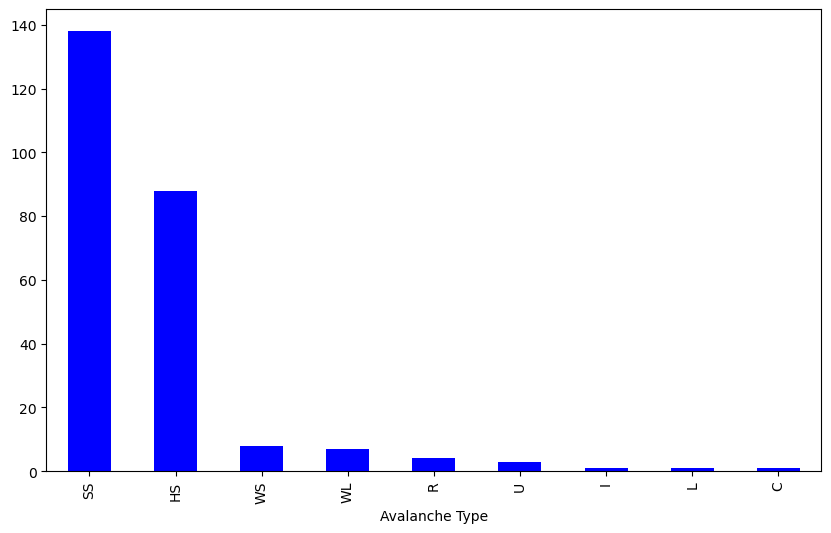

In [345]:
avalanche_df['Avalanche Type'].value_counts().plot(kind='bar', figsize=(10, 6), color='blue')

In [346]:
print(avalanche_df['Avalanche Type'].value_counts())

Avalanche Type
SS    138
HS     88
WS      8
WL      7
R       4
U       3
I       1
L       1
C       1
Name: count, dtype: int64


In [347]:
#Now I will filter the avalanche dataframe to only the avalanche type I want to keep for my model
avalanche_df = avalanche_df[avalanche_df['Avalanche Type'].isin(['SS', 'HS', 'WS', 'WL'])]

In [348]:
#And now we can see that we successfully dropped the rows that contain the unwanted avalanche types
#This is still obviously imbalanced! 
print(avalanche_df['Avalanche Type'].value_counts())

Avalanche Type
SS    138
HS     88
WS      8
WL      7
Name: count, dtype: int64


In [349]:
#I'll reset the index now 
avalanche_df.reset_index(drop=True, inplace=True)

In [350]:
#We now have 241 rows of data to use.
len(avalanche_df)

241

In [351]:
#I'm now going to try to use Open Meteo API to pull historical weather data.
#Developed with assistance from Open Meteo documentation and ChatGPT

def get_historical_weather(row):

    try: 
        lat = float(row['Latitude'])
        lon = float(row['Longitude'])
        accident_date = pd.to_datetime(row['Date'], errors='coerce') #Only use the day since time is the time of reporting, not time of incident / accident
       
        if pd.isna(accident_date):
                raise ValueError("Unparseable Date")
        accident_date = accident_date.date()
        
    except Exception:
        return {
            "Avg Temperature": None,
            "Max Temperature": None,
            "Min Temperature": None,
            "Snowfall": None,
            "Snowfall 72h": None, 
            "Avg Windspeed": None,
            "Max Windspeed": None,
            "Min Windspeed": None,
            "Wind Direction": None,
        }


    #Define the Units.
    unit_params = "&temperature_unit=fahrenheit&windspeed_unit=mph&precipitation_unit=inch"
    tz = "America/Denver"

    #Fetch the three day weather window for 72h snowfall
    start_date = (accident_date - timedelta(days=2)).isoformat()
    end_date = accident_date.isoformat()
    
    # Build request
    url = (
        "https://archive-api.open-meteo.com/v1/archive"
        f"?latitude={lat}&longitude={lon}"
        f"&start_date={start_date}&end_date={end_date}"
        "&daily=temperature_2m_mean,temperature_2m_max,temperature_2m_min,"
        "snowfall_sum,windspeed_10m_mean,windspeed_10m_max,windspeed_10m_min,winddirection_10m_dominant"
        f"&timezone={tz}{unit_params}"
    )

    
    try:
        r = requests.get(url, timeout = 20)
        r.raise_for_status()
        data = r.json()

        # Default output
        out = {
            "Avg Temperature": None,
            "Max Temperature": None,
            "Min Temperature": None,
            "Snowfall": None,
            "Snowfall 72h": None,
            "Avg Windspeed": None,
            "Max Windspeed": None,
            "Min Windspeed": None,
            "Wind Direction": None,
        }

        #If no daily then return default output
        if "daily" not in data: 
            print("Daily not in data")
            return out

      
        d = data["daily"]

        def last_or_none(key):
            vals = d.get(key, [])
            return vals[-1] if vals else None

        #Get the "same day" values (the last element in the 3 day list)
        out["Avg Temperature"] = last_or_none("temperature_2m_mean")
        out["Max Temperature"] = last_or_none("temperature_2m_max")
        out["Min Temperature"] = last_or_none("temperature_2m_min")
        out["Snowfall"]        = last_or_none("snowfall_sum")
        out["Avg Windspeed"]   = last_or_none("windspeed_10m_mean")
        out["Max Windspeed"]   = last_or_none("windspeed_10m_max")
        out["Min Windspeed"]   = last_or_none("windspeed_10m_min")
        out["Wind Direction"]  = last_or_none("winddirection_10m_dominant")

        snow_list = d.get("snowfall_sum", [])
        if snow_list:
            out["Snowfall 72h"] = float(pd.to_numeric(pd.Series(snow_list), errors="coerce").sum())

        
        return out

    except Exception:
        return {
            "Avg Temperature": None,
            "Max Temperature": None,
            "Min Temperature": None,
            "Snowfall": None,
            "Snowfall 72h": None,
            "Avg Windspeed": None,
            "Max Windspeed": None,
            "Min Windspeed": None,
            "Wind Direction": None,
        }

In [352]:
weather_cols = avalanche_df.apply(get_historical_weather, axis=1, result_type="expand")

In [353]:
weather_cols.describe()

,Avg Temperature,Max Temperature,Min Temperature,Snowfall,Snowfall 72h,Avg Windspeed,Max Windspeed,Min Windspeed,Wind Direction
count,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000,241.000000
mean,14.990041,24.525311,5.807469,0.690145,2.527788,5.973444,9.523651,2.973029,255.024896
std,8.960584,9.199256,10.237481,1.155649,2.711332,2.307172,3.312473,1.840759,64.936952
min,-11.400000,-2.300000,-21.900000,0.000000,0.000000,1.500000,2.900000,0.000000,6.000000
25%,9.300000,18.600000,-0.100000,0.000000,0.441000,4.300000,6.800000,1.600000,236.000000
50%,14.300000,23.200000,5.600000,0.138000,1.709000,5.700000,9.300000,2.700000,271.000000
75%,20.300000,29.700000,13.400000,1.047000,3.528000,7.500000,11.500000,4.000000,292.000000
max,43.900000,56.800000,31.400000,7.083000,13.752000,12.900000,18.300000,8.400000,353.000000


In [354]:
weather_cols.head()

,Avg Temperature,Max Temperature,Min Temperature,Snowfall,Snowfall 72h,Avg Windspeed,Max Windspeed,Min Windspeed,Wind Direction
0,-3.1,3.9,-11.9,0.110,3.969,4.8,7.8,2.6,217.0
1,16.1,35.9,1.3,0.000,0.331,3.5,4.9,0.5,270.0
2,14.3,31.1,0.6,0.000,0.634,5.7,8.8,1.9,291.0
3,19.1,23.2,13.3,3.307,6.090,7.8,11.2,3.2,259.0
4,17.1,27.3,4.1,1.791,3.913,4.8,7.9,2.1,315.0


In [355]:
#There are no missing rows in the weather_cols and they share the same index. I will merge them together now.
avalanche_df = pd.concat([avalanche_df, weather_cols], axis = 1)

In [356]:
avalanche_df.head()

,Date,Season,Latitude,Longitude,Avalanche Type,Aspect,Elevation,Slope Degree,Avg Temperature,Max Temperature,Min Temperature,Snowfall,Snowfall 72h,Avg Windspeed,Max Windspeed,Min Windspeed,Wind Direction
0,2018-02-20 07:00:00,Mid Season,38.00888,-107.87307,HS,N,11400,38.787527,-3.1,3.9,-11.9,0.110,3.969,4.8,7.8,2.6,217.0
1,2018-01-14 19:00:00,Mid Season,38.68906,-106.35538,SS,NE,11200,35.000000,16.1,35.9,1.3,0.000,0.331,3.5,4.9,0.5,270.0
2,2010-03-12 07:00:00,Late Season,38.32872,-106.23696,SS,W,12000,41.614486,14.3,31.1,0.6,0.000,0.634,5.7,8.8,1.9,291.0
3,2019-03-07 07:00:00,Late Season,39.49174,-106.11663,HS,W,11900,36.775005,19.1,23.2,13.3,3.307,6.090,7.8,11.2,3.2,259.0
4,2013-11-24 17:30:00,Early Season,39.83408,-105.64865,SS,E,11194,42.112037,17.1,27.3,4.1,1.791,3.913,4.8,7.9,2.1,315.0


In [357]:
#We've extracted everything we need from Date, Latitude, and Longitude. I'm gonna drop them
avalanche_df = avalanche_df.drop(columns = ['Date','Latitude','Longitude'])

In [358]:
#Next I'm going to convert aspect to be degrees to match the wind direction.
aspect_degrees = {
    'N': 0,
    'NE' : 45,
    'E' : 90,
    'SE' : 135,
    'S' : 180,
    'SW' : 225,
    'W' : 270,
    'NW' : 315
}

avalanche_df['Aspect'] = avalanche_df['Aspect'].map(aspect_degrees)

In [365]:
#I'm also going to round slope degree to reduce unecessary precision
avalanche_df['Slope Degree'] = avalanche_df['Slope Degree'].round(1)

#And will also round Snowfall 72h
avalanche_df['Snowfall 72h'] = avalanche_df['Snowfall 72h'].round(1)

In [375]:
avalanche_df.head()

,Season,Avalanche Type,Aspect,Elevation,Slope Degree,Avg Temperature,Max Temperature,Min Temperature,Snowfall,Snowfall 72h,Avg Windspeed,Max Windspeed,Min Windspeed,Wind Direction
0,Mid Season,HS,0,11400,38.8,-3.1,3.9,-11.9,0.110,4.0,4.8,7.8,2.6,217.0
1,Mid Season,SS,45,11200,35.0,16.1,35.9,1.3,0.000,0.3,3.5,4.9,0.5,270.0
2,Late Season,SS,270,12000,41.6,14.3,31.1,0.6,0.000,0.6,5.7,8.8,1.9,291.0
3,Late Season,HS,270,11900,36.8,19.1,23.2,13.3,3.307,6.1,7.8,11.2,3.2,259.0
4,Early Season,SS,90,11194,42.1,17.1,27.3,4.1,1.791,3.9,4.8,7.9,2.1,315.0


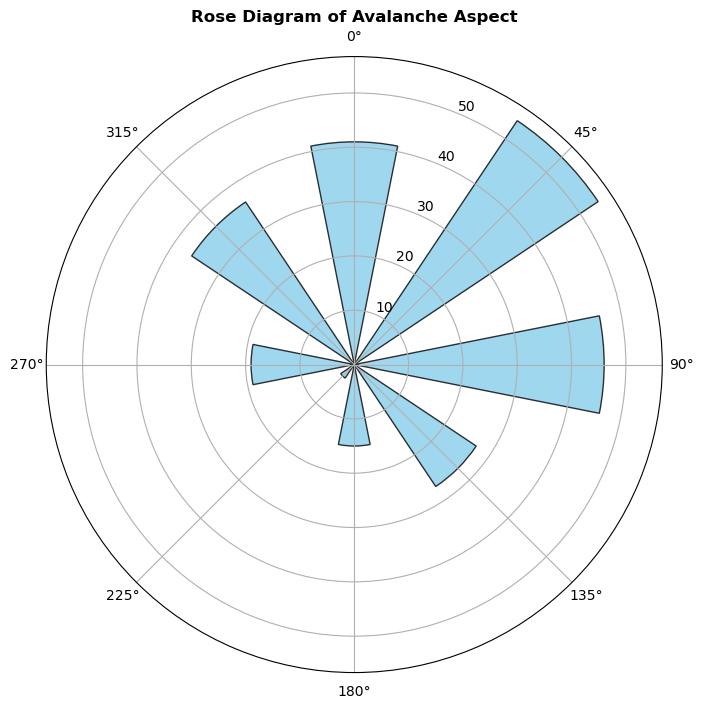

In [514]:
color_map = {
    'SS': 'red',
    'HS': 'blue',
    'WS': 'green',
    'WL': 'yellow' 
}

#Convert to radians
aspect_radians = np.deg2rad(avalanche_df['Aspect'])

#Make bins for every 22.5 degrees
num_bins = 16
bins = np.linspace(0, 2*np.pi, num_bins + 1)

counts, _ = np.histogram(aspect_radians, bins)

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

bars = ax.bar(bins[:-1], counts, width=(2*np.pi/num_bins), bottom=0, color='skyblue', edgecolor='black', alpha=0.8)

ax.set_theta_zero_location('N')  # 0° at the top
ax.set_theta_direction(-1)       # Clockwise
ax.set_title("Rose Diagram of Avalanche Aspect", fontweight='bold')

plt.show()


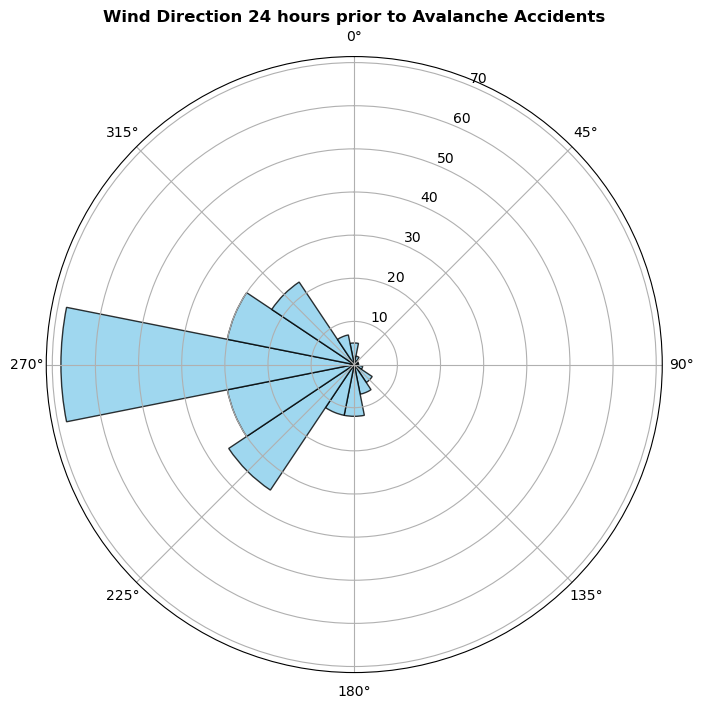

In [513]:
color_map = {
    'SS': 'red',
    'HS': 'blue',
    'WS': 'green',
    'WL': 'yellow' 
}

#Convert to radians
aspect_radians = np.deg2rad(avalanche_df['Wind Direction'])

#Make bins for every 22.5 degrees
num_bins = 16
bins = np.linspace(0, 2*np.pi, num_bins + 1)

counts, _ = np.histogram(aspect_radians, bins)

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

bars = ax.bar(bins[:-1], counts, width=(2*np.pi/num_bins), bottom=0, color='skyblue', edgecolor='black', alpha=0.8)

ax.set_theta_zero_location('N')  # 0° at the top
ax.set_theta_direction(-1)       # Clockwise
ax.set_title("Wind Direction 24 hours prior to Avalanche Accidents", fontweight='bold')

plt.show()

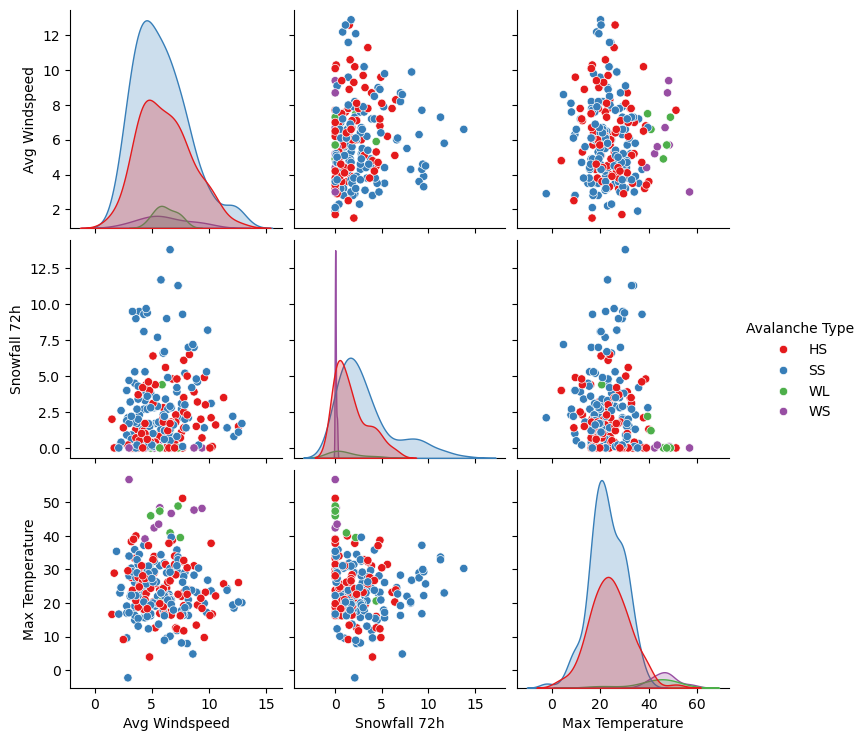

In [508]:
sns.pairplot(
    data=avalanche_df,
    vars=['Avg Windspeed', 'Snowfall 72h', 'Max Temperature'],
    hue='Avalanche Type',
    palette='Set1',
    diag_kind='kde' 
)